In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
np.random.seed(0)

In [3]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
errors = np.sqrt(np.abs(np.diagonal(syscov)))

### Generate a data set with covariance matrix from the original plus gaussian noise

In [4]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.001 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 770 matrix 

 Generating 1000 matrix 

In [5]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))


(1000, 31, 31)


In [6]:
from astroNN.nn.layers import MCDropout

In [7]:
# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img2 = tf.keras.Input(shape=(31*31,))
# begin encoder
x2 = layers.Dense(100, activation='tanh')(input_img2)
x2 = MCDropout(0.1)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
encoded2 = layers.Dense(encoding_dim, activation='tanh')(x2)
x2 = MCDropout(0.1)(encoded2)
#begin decoder
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
decoded2 = layers.Dense(31*31, activation='linear')(x2)


# This model maps an input to its reconstruction
autoencoder2 = tf.keras.Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 31)               

In [8]:
autoencoder2_train = autoencoder2.fit(covset_noise_train, covset_train,
                    epochs=1000,                                    
                    batch_size=32,
                    shuffle=True,
                    validation_data=(covset_noise_test, covset_test))
#                     callbacks=callbacks)

Epoch 1/1000
25/25 [==============================] - 0s 14ms/step - loss: 2.9479e-06 - val_loss: 1.8687e-06
Epoch 2/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.6483e-06 - val_loss: 1.5886e-06
Epoch 3/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.5157e-06 - val_loss: 1.4846e-06
Epoch 4/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.4965e-06 - val_loss: 1.4831e-06
Epoch 5/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.4694e-06 - val_loss: 1.4899e-06
Epoch 6/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.4360e-06 - val_loss: 1.4396e-06
Epoch 7/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.4430e-06 - val_loss: 1.4621e-06
Epoch 8/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.4135e-06 - val_loss: 1.4158e-06
Epoch 9/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.4035e-06 - val_loss: 1.4323e-06
Epoch 10/1000
25/25 [======

25/25 [==============================] - 0s 5ms/step - loss: 1.1190e-06 - val_loss: 1.1495e-06
Epoch 77/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.1142e-06 - val_loss: 1.1306e-06
Epoch 78/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.1130e-06 - val_loss: 1.1329e-06
Epoch 79/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.1122e-06 - val_loss: 1.1313e-06
Epoch 80/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.1115e-06 - val_loss: 1.1397e-06
Epoch 81/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.1151e-06 - val_loss: 1.1412e-06
Epoch 82/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.1124e-06 - val_loss: 1.1310e-06
Epoch 83/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.1158e-06 - val_loss: 1.1318e-06
Epoch 84/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.1149e-06 - val_loss: 1.1441e-06
Epoch 85/1000
25/25 [============

Epoch 151/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0809e-06 - val_loss: 1.1001e-06
Epoch 152/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0833e-06 - val_loss: 1.1002e-06
Epoch 153/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0806e-06 - val_loss: 1.1003e-06
Epoch 154/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0840e-06 - val_loss: 1.1046e-06
Epoch 155/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0837e-06 - val_loss: 1.1009e-06
Epoch 156/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.0840e-06 - val_loss: 1.0989e-06
Epoch 157/1000
25/25 [==============================] - 0s 7ms/step - loss: 1.0833e-06 - val_loss: 1.0984e-06
Epoch 158/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0821e-06 - val_loss: 1.0936e-06
Epoch 159/1000
25/25 [==============================] - 0s 7ms/step - loss: 1.0837e-06 - val_loss: 1.1027e-06
Epoch 160/

25/25 [==============================] - 0s 7ms/step - loss: 1.0757e-06 - val_loss: 1.0886e-06
Epoch 226/1000
25/25 [==============================] - 0s 10ms/step - loss: 1.0737e-06 - val_loss: 1.0925e-06
Epoch 227/1000
25/25 [==============================] - 0s 8ms/step - loss: 1.0709e-06 - val_loss: 1.0878e-06
Epoch 228/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.0714e-06 - val_loss: 1.0877e-06
Epoch 229/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.0716e-06 - val_loss: 1.0887e-06
Epoch 230/1000
25/25 [==============================] - 0s 7ms/step - loss: 1.0733e-06 - val_loss: 1.0920e-06
Epoch 231/1000
25/25 [==============================] - 0s 7ms/step - loss: 1.0756e-06 - val_loss: 1.0845e-06
Epoch 232/1000
25/25 [==============================] - 0s 9ms/step - loss: 1.0707e-06 - val_loss: 1.0830e-06
Epoch 233/1000
25/25 [==============================] - 0s 7ms/step - loss: 1.0704e-06 - val_loss: 1.0845e-06
Epoch 234/1000
25/25 [==

25/25 [==============================] - 0s 7ms/step - loss: 1.0660e-06 - val_loss: 1.0797e-06
Epoch 300/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0702e-06 - val_loss: 1.0875e-06
Epoch 301/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0699e-06 - val_loss: 1.0837e-06
Epoch 302/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.0661e-06 - val_loss: 1.0865e-06
Epoch 303/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0652e-06 - val_loss: 1.0811e-06
Epoch 304/1000
25/25 [==============================] - 0s 7ms/step - loss: 1.0682e-06 - val_loss: 1.0856e-06
Epoch 305/1000
25/25 [==============================] - 0s 7ms/step - loss: 1.0664e-06 - val_loss: 1.0790e-06
Epoch 306/1000
25/25 [==============================] - 0s 7ms/step - loss: 1.0673e-06 - val_loss: 1.0852e-06
Epoch 307/1000
25/25 [==============================] - 0s 8ms/step - loss: 1.0665e-06 - val_loss: 1.0806e-06
Epoch 308/1000
25/25 [===

25/25 [==============================] - 0s 5ms/step - loss: 1.0638e-06 - val_loss: 1.0771e-06
Epoch 374/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0610e-06 - val_loss: 1.0746e-06
Epoch 375/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0649e-06 - val_loss: 1.0762e-06
Epoch 376/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0643e-06 - val_loss: 1.0922e-06
Epoch 377/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0699e-06 - val_loss: 1.0800e-06
Epoch 378/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0631e-06 - val_loss: 1.0730e-06
Epoch 379/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0628e-06 - val_loss: 1.0858e-06
Epoch 380/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0654e-06 - val_loss: 1.0757e-06
Epoch 381/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0623e-06 - val_loss: 1.0747e-06
Epoch 382/1000
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0646e-06 - val_loss: 1.0752e-06
Epoch 448/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0606e-06 - val_loss: 1.0730e-06
Epoch 449/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0596e-06 - val_loss: 1.0698e-06
Epoch 450/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0626e-06 - val_loss: 1.0782e-06
Epoch 451/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0625e-06 - val_loss: 1.0736e-06
Epoch 452/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0630e-06 - val_loss: 1.0707e-06
Epoch 453/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0596e-06 - val_loss: 1.0691e-06
Epoch 454/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0625e-06 - val_loss: 1.0697e-06
Epoch 455/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0606e-06 - val_loss: 1.0780e-06
Epoch 456/1000
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0602e-06 - val_loss: 1.0746e-06
Epoch 522/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0619e-06 - val_loss: 1.0707e-06
Epoch 523/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0628e-06 - val_loss: 1.0844e-06
Epoch 524/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0639e-06 - val_loss: 1.0757e-06
Epoch 525/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0578e-06 - val_loss: 1.0746e-06
Epoch 526/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0606e-06 - val_loss: 1.0701e-06
Epoch 527/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0608e-06 - val_loss: 1.0773e-06
Epoch 528/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.0653e-06 - val_loss: 1.0759e-06
Epoch 529/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.0618e-06 - val_loss: 1.0694e-06
Epoch 530/1000
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0589e-06 - val_loss: 1.0711e-06
Epoch 596/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0606e-06 - val_loss: 1.0728e-06
Epoch 597/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0613e-06 - val_loss: 1.0798e-06
Epoch 598/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0614e-06 - val_loss: 1.0733e-06
Epoch 599/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0574e-06 - val_loss: 1.0678e-06
Epoch 600/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0607e-06 - val_loss: 1.0687e-06
Epoch 601/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0607e-06 - val_loss: 1.0721e-06
Epoch 602/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0587e-06 - val_loss: 1.0727e-06
Epoch 603/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0582e-06 - val_loss: 1.0699e-06
Epoch 604/1000
25/25 [===

25/25 [==============================] - 0s 7ms/step - loss: 1.0618e-06 - val_loss: 1.0737e-06
Epoch 670/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0571e-06 - val_loss: 1.0733e-06
Epoch 671/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0582e-06 - val_loss: 1.0704e-06
Epoch 672/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0559e-06 - val_loss: 1.0677e-06
Epoch 673/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0556e-06 - val_loss: 1.0674e-06
Epoch 674/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0563e-06 - val_loss: 1.0659e-06
Epoch 675/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0576e-06 - val_loss: 1.0681e-06
Epoch 676/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.0595e-06 - val_loss: 1.0779e-06
Epoch 677/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0635e-06 - val_loss: 1.0747e-06
Epoch 678/1000
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0571e-06 - val_loss: 1.0728e-06
Epoch 744/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0597e-06 - val_loss: 1.0755e-06
Epoch 745/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0590e-06 - val_loss: 1.0663e-06
Epoch 746/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0581e-06 - val_loss: 1.0725e-06
Epoch 747/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.0598e-06 - val_loss: 1.0756e-06
Epoch 748/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0579e-06 - val_loss: 1.0680e-06
Epoch 749/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0578e-06 - val_loss: 1.0696e-06
Epoch 750/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0555e-06 - val_loss: 1.0737e-06
Epoch 751/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0570e-06 - val_loss: 1.0712e-06
Epoch 752/1000
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0569e-06 - val_loss: 1.0659e-06
Epoch 818/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0558e-06 - val_loss: 1.0667e-06
Epoch 819/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0570e-06 - val_loss: 1.0685e-06
Epoch 820/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0592e-06 - val_loss: 1.0692e-06
Epoch 821/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0586e-06 - val_loss: 1.0720e-06
Epoch 822/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0577e-06 - val_loss: 1.0776e-06
Epoch 823/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0558e-06 - val_loss: 1.0636e-06
Epoch 824/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0563e-06 - val_loss: 1.0791e-06
Epoch 825/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0571e-06 - val_loss: 1.0664e-06
Epoch 826/1000
25/25 [===

25/25 [==============================] - 0s 5ms/step - loss: 1.0551e-06 - val_loss: 1.0698e-06
Epoch 892/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0573e-06 - val_loss: 1.0704e-06
Epoch 893/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0551e-06 - val_loss: 1.0675e-06
Epoch 894/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0544e-06 - val_loss: 1.0714e-06
Epoch 895/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.0566e-06 - val_loss: 1.0708e-06
Epoch 896/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0544e-06 - val_loss: 1.0684e-06
Epoch 897/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0543e-06 - val_loss: 1.0711e-06
Epoch 898/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0533e-06 - val_loss: 1.0688e-06
Epoch 899/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0541e-06 - val_loss: 1.0731e-06
Epoch 900/1000
25/25 [===

25/25 [==============================] - 0s 5ms/step - loss: 1.0543e-06 - val_loss: 1.0643e-06
Epoch 966/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0541e-06 - val_loss: 1.0665e-06
Epoch 967/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0544e-06 - val_loss: 1.0678e-06
Epoch 968/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0551e-06 - val_loss: 1.0702e-06
Epoch 969/1000
25/25 [==============================] - 0s 3ms/step - loss: 1.0563e-06 - val_loss: 1.0696e-06
Epoch 970/1000
25/25 [==============================] - 0s 3ms/step - loss: 1.0541e-06 - val_loss: 1.0685e-06
Epoch 971/1000
25/25 [==============================] - 0s 3ms/step - loss: 1.0526e-06 - val_loss: 1.0738e-06
Epoch 972/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0547e-06 - val_loss: 1.0595e-06
Epoch 973/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.0526e-06 - val_loss: 1.0672e-06
Epoch 974/1000
25/25 [===

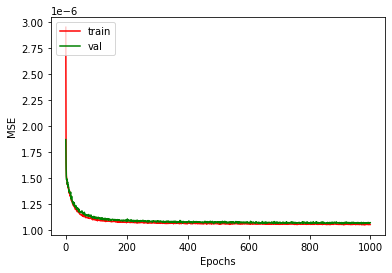

In [9]:
plt.plot(autoencoder2_train.history['loss'], color='r', )
plt.plot(autoencoder2_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('loss_binned_JLAdropout.png', dpi=200)

In [10]:
encoder2 = tf.keras.Model(input_img2, encoded2)
# This is our encoded (32-dimensional) input
encoded2_input = tf.keras.Input(shape=(encoding_dim,))

decoder2_layer1 = autoencoder2.layers[-5]
decoder2_layer2 = autoencoder2.layers[-4]
decoder2_layer3 = autoencoder2.layers[-3]
decoder2_layer4 = autoencoder2.layers[-2]
decoder2_layer5 = autoencoder2.layers[-1]

# create the decoder model
decoder2 = Model(encoded2_input, 
                decoder2_layer5(decoder2_layer4(decoder2_layer3(decoder2_layer2(decoder2_layer1(encoded2_input))))))

In [11]:
decoder2.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3200      
_________________________________________________________________
MCDropout_4 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
MCDropout_5 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 961)               97061     
Total params: 110,361
Trainable params: 110,361
Non-trainable params: 0
________________________________________________

In [12]:
encoded_imgs = encoder2.predict(covset_test)
decoded_imgs = decoder2.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)


(200, 31)


In [13]:
fake_encoded = np.zeros((1, 31))
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)

(1, 31)


In [14]:
# Generate test data
test_batch_size = 31*31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0, 2., test_batch_size)
mc_dropout_num = 100  # Run Dropout 100 times
predictions_dec = np.zeros((mc_dropout_num, 1, test_batch_size))
uncertainty = np.zeros((mc_dropout_num, 1, test_batch_size))
for i in range(mc_dropout_num):
    predictions_dec[i] = decoder2.predict(fake_encoded)
    
# get mean results and its varience
prediction_mc_dropout_dec = np.mean(predictions_dec, axis=0, dtype=np.float64)
std_mc_dropout_dec = np.std(predictions_dec, axis=0, dtype=np.float64)
np.shape(prediction_mc_dropout_dec), np.shape(std_mc_dropout_dec)

((1, 961), (1, 961))

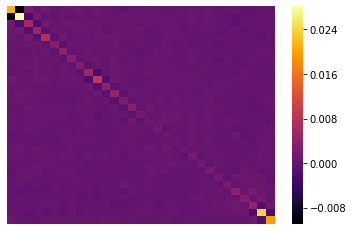

In [15]:
sns.heatmap(pd.DataFrame(prediction_mc_dropout_dec[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

# FFNN

In [16]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)

shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]

z = data[:,0]
dl = data[:,1:]
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))
z_train, z_test = np.split(zz, indx)
dl_train, dl_test = np.split(dl, indx)



In [17]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.01)(efirst)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.01)(x)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.01)(x)
    x = Dense(30, activation='relu')(x)
    x = MCDropout(0.01)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                100       
_________________________________________________________________
MCDropout_6 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
MCDropout_7 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
MCDropout_8 (MCDropout)      (None, 50)               

In [18]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=1,
                                    epochs=2000,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/2000
24/24 [==============================] - 0s 8ms/step - loss: 1439.8247 - val_loss: 1734.2955
Epoch 2/2000
24/24 [==============================] - 0s 2ms/step - loss: 1408.8778 - val_loss: 1692.7023
Epoch 3/2000
24/24 [==============================] - 0s 2ms/step - loss: 1289.5908 - val_loss: 1530.6882
Epoch 4/2000
24/24 [==============================] - 0s 2ms/step - loss: 815.1287 - val_loss: 877.2210
Epoch 5/2000
24/24 [==============================] - 0s 2ms/step - loss: 205.6654 - val_loss: 262.8720
Epoch 6/2000
24/24 [==============================] - 0s 2ms/step - loss: 133.6867 - val_loss: 208.8221
Epoch 7/2000
24/24 [==============================] - 0s 2ms/step - loss: 78.1183 - val_loss: 183.0452
Epoch 8/2000
24/24 [==============================] - 0s 2ms/step - loss: 70.3030 - val_loss: 126.4217
Epoch 9/2000
24/24 [==============================] - 0s 2ms/step - loss: 64.1685 - val_loss: 145.7048
Epoch 10/2000
24/24 [==============================] - 0s 2ms

24/24 [==============================] - 0s 2ms/step - loss: 3.0603 - val_loss: 6.9051
Epoch 82/2000
24/24 [==============================] - 0s 2ms/step - loss: 8.1358 - val_loss: 6.9967
Epoch 83/2000
24/24 [==============================] - 0s 2ms/step - loss: 8.7075 - val_loss: 7.4543
Epoch 84/2000
24/24 [==============================] - 0s 2ms/step - loss: 6.5329 - val_loss: 0.5024
Epoch 85/2000
24/24 [==============================] - 0s 3ms/step - loss: 4.8255 - val_loss: 7.0840
Epoch 86/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.9230 - val_loss: 1.9374
Epoch 87/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.5098 - val_loss: 3.6526
Epoch 88/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.5260 - val_loss: 0.6929
Epoch 89/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.8758 - val_loss: 3.0718
Epoch 90/2000
24/24 [==============================] - 0s 2ms/step - loss: 5.2252 - val_loss: 6.4058
Epoc

24/24 [==============================] - 0s 2ms/step - loss: 3.1218 - val_loss: 0.6729
Epoch 162/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.2245 - val_loss: 8.0207
Epoch 163/2000
24/24 [==============================] - 0s 2ms/step - loss: 6.3591 - val_loss: 1.0202
Epoch 164/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.0376 - val_loss: 1.6030
Epoch 165/2000
24/24 [==============================] - 0s 3ms/step - loss: 5.9421 - val_loss: 2.1336
Epoch 166/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.1863 - val_loss: 3.5105
Epoch 167/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.8000 - val_loss: 2.9228
Epoch 168/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.6863 - val_loss: 1.5222
Epoch 169/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.2980 - val_loss: 3.5801
Epoch 170/2000
24/24 [==============================] - 0s 2ms/step - loss: 7.8366 - val_loss: 2.

24/24 [==============================] - 0s 2ms/step - loss: 4.7482 - val_loss: 3.2737
Epoch 242/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.3885 - val_loss: 6.3642
Epoch 243/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.6389 - val_loss: 2.5768
Epoch 244/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.6826 - val_loss: 5.0202
Epoch 245/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.9011 - val_loss: 3.5966
Epoch 246/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.9951 - val_loss: 3.9125
Epoch 247/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.5825 - val_loss: 7.3857
Epoch 248/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.6369 - val_loss: 4.4395
Epoch 249/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.7905 - val_loss: 1.2408
Epoch 250/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.1217 - val_loss: 2.

24/24 [==============================] - 0s 2ms/step - loss: 3.9168 - val_loss: 5.7878
Epoch 322/2000
24/24 [==============================] - 0s 2ms/step - loss: 5.2300 - val_loss: 2.4352
Epoch 323/2000
24/24 [==============================] - 0s 3ms/step - loss: 4.1316 - val_loss: 1.6991
Epoch 324/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.8728 - val_loss: 2.9060
Epoch 325/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.0401 - val_loss: 7.2954
Epoch 326/2000
24/24 [==============================] - 0s 3ms/step - loss: 7.8192 - val_loss: 4.4635
Epoch 327/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.4875 - val_loss: 1.4666
Epoch 328/2000
24/24 [==============================] - 0s 3ms/step - loss: 5.7103 - val_loss: 4.1676
Epoch 329/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.5293 - val_loss: 0.9127
Epoch 330/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.7506 - val_loss: 0.

24/24 [==============================] - 0s 3ms/step - loss: 3.5761 - val_loss: 6.5561
Epoch 402/2000
24/24 [==============================] - 0s 3ms/step - loss: 4.9386 - val_loss: 1.4186
Epoch 403/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.4451 - val_loss: 1.5457
Epoch 404/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.2490 - val_loss: 0.5115
Epoch 405/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.0178 - val_loss: 4.5876
Epoch 406/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.2235 - val_loss: 2.3832
Epoch 407/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.5210 - val_loss: 2.8660
Epoch 408/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.0136 - val_loss: 2.2402
Epoch 409/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.1908 - val_loss: 3.2481
Epoch 410/2000
24/24 [==============================] - 0s 2ms/step - loss: 6.9004 - val_loss: 0.

24/24 [==============================] - 0s 2ms/step - loss: 4.1555 - val_loss: 0.3667
Epoch 482/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.8378 - val_loss: 2.6833
Epoch 483/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.5986 - val_loss: 1.2398
Epoch 484/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.9823 - val_loss: 3.4988
Epoch 485/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.3423 - val_loss: 7.4870
Epoch 486/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.8827 - val_loss: 0.9487
Epoch 487/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.8461 - val_loss: 7.6985
Epoch 488/2000
24/24 [==============================] - 0s 2ms/step - loss: 5.6266 - val_loss: 9.3922
Epoch 489/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.9335 - val_loss: 5.5518
Epoch 490/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.1492 - val_loss: 12

24/24 [==============================] - 0s 3ms/step - loss: 5.0213 - val_loss: 2.0245
Epoch 562/2000
24/24 [==============================] - 0s 3ms/step - loss: 4.2536 - val_loss: 3.7115
Epoch 563/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.4324 - val_loss: 2.2058
Epoch 564/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.5374 - val_loss: 1.1172
Epoch 565/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.9333 - val_loss: 3.7861
Epoch 566/2000
24/24 [==============================] - 0s 3ms/step - loss: 7.4451 - val_loss: 7.7965
Epoch 567/2000
24/24 [==============================] - 0s 3ms/step - loss: 5.5819 - val_loss: 8.9297
Epoch 568/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.4448 - val_loss: 3.5832
Epoch 569/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.9503 - val_loss: 0.3342
Epoch 570/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.8364 - val_loss: 17

24/24 [==============================] - 0s 3ms/step - loss: 2.5504 - val_loss: 2.5022
Epoch 642/2000
24/24 [==============================] - 0s 2ms/step - loss: 8.0661 - val_loss: 2.0875
Epoch 643/2000
24/24 [==============================] - 0s 2ms/step - loss: 5.4219 - val_loss: 2.9443
Epoch 644/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.2481 - val_loss: 3.4300
Epoch 645/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.7540 - val_loss: 0.9246
Epoch 646/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.7389 - val_loss: 1.1954
Epoch 647/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.0549 - val_loss: 4.0979
Epoch 648/2000
24/24 [==============================] - 0s 4ms/step - loss: 4.6414 - val_loss: 3.4115
Epoch 649/2000
24/24 [==============================] - 0s 3ms/step - loss: 4.2821 - val_loss: 3.7680
Epoch 650/2000
24/24 [==============================] - 0s 2ms/step - loss: 7.2200 - val_loss: 2.

24/24 [==============================] - 0s 2ms/step - loss: 4.2737 - val_loss: 3.1526
Epoch 722/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.9651 - val_loss: 1.2749
Epoch 723/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.7379 - val_loss: 2.1451
Epoch 724/2000
24/24 [==============================] - 0s 3ms/step - loss: 0.9868 - val_loss: 0.7655
Epoch 725/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.8113 - val_loss: 3.9846
Epoch 726/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.0594 - val_loss: 2.7945
Epoch 727/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.2491 - val_loss: 7.5711
Epoch 728/2000
24/24 [==============================] - 0s 3ms/step - loss: 7.7507 - val_loss: 3.7736
Epoch 729/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.6380 - val_loss: 7.3152
Epoch 730/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.2777 - val_loss: 1.

24/24 [==============================] - 0s 4ms/step - loss: 6.8195 - val_loss: 2.6194
Epoch 802/2000
24/24 [==============================] - 0s 4ms/step - loss: 2.5779 - val_loss: 0.9013
Epoch 803/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.3075 - val_loss: 7.4245
Epoch 804/2000
24/24 [==============================] - 0s 4ms/step - loss: 4.8322 - val_loss: 12.5219
Epoch 805/2000
24/24 [==============================] - 0s 4ms/step - loss: 6.2277 - val_loss: 3.0093
Epoch 806/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.5150 - val_loss: 4.2675
Epoch 807/2000
24/24 [==============================] - 0s 4ms/step - loss: 5.1702 - val_loss: 2.7205
Epoch 808/2000
24/24 [==============================] - 0s 3ms/step - loss: 4.3384 - val_loss: 4.9778
Epoch 809/2000
24/24 [==============================] - 0s 4ms/step - loss: 3.0259 - val_loss: 2.6759
Epoch 810/2000
24/24 [==============================] - 0s 4ms/step - loss: 3.0965 - val_loss: 3

24/24 [==============================] - 0s 2ms/step - loss: 0.9443 - val_loss: 2.1239
Epoch 882/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.7494 - val_loss: 1.4726
Epoch 883/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.8549 - val_loss: 5.0705
Epoch 884/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.1851 - val_loss: 0.8123
Epoch 885/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.5076 - val_loss: 9.0525
Epoch 886/2000
24/24 [==============================] - 0s 4ms/step - loss: 1.8200 - val_loss: 7.1711
Epoch 887/2000
24/24 [==============================] - 0s 4ms/step - loss: 7.4685 - val_loss: 4.9971
Epoch 888/2000
24/24 [==============================] - 0s 4ms/step - loss: 4.5400 - val_loss: 1.8829
Epoch 889/2000
24/24 [==============================] - 0s 4ms/step - loss: 2.1525 - val_loss: 3.7420
Epoch 890/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.4350 - val_loss: 0.

24/24 [==============================] - 0s 3ms/step - loss: 3.7100 - val_loss: 7.6943
Epoch 962/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.6642 - val_loss: 3.8016
Epoch 963/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.4020 - val_loss: 2.9308
Epoch 964/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.8428 - val_loss: 5.8853
Epoch 965/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.5874 - val_loss: 3.7461
Epoch 966/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.3112 - val_loss: 6.0491
Epoch 967/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.8503 - val_loss: 2.3625
Epoch 968/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.3972 - val_loss: 2.2458
Epoch 969/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.9419 - val_loss: 3.6525
Epoch 970/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.2119 - val_loss: 1.

24/24 [==============================] - 0s 3ms/step - loss: 5.9181 - val_loss: 7.1033
Epoch 1042/2000
24/24 [==============================] - 0s 3ms/step - loss: 4.4225 - val_loss: 0.3793
Epoch 1043/2000
24/24 [==============================] - 0s 4ms/step - loss: 1.5311 - val_loss: 3.7456
Epoch 1044/2000
24/24 [==============================] - 0s 5ms/step - loss: 4.3210 - val_loss: 2.7121
Epoch 1045/2000
24/24 [==============================] - 0s 5ms/step - loss: 1.1378 - val_loss: 0.9050
Epoch 1046/2000
24/24 [==============================] - 0s 5ms/step - loss: 3.6135 - val_loss: 5.1272
Epoch 1047/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.5608 - val_loss: 4.7612
Epoch 1048/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.8694 - val_loss: 1.8960
Epoch 1049/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.3065 - val_loss: 8.0376
Epoch 1050/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.7226 - val

24/24 [==============================] - 0s 3ms/step - loss: 2.8117 - val_loss: 1.7862
Epoch 1121/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.9525 - val_loss: 2.2860
Epoch 1122/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.6237 - val_loss: 0.9059
Epoch 1123/2000
24/24 [==============================] - 0s 4ms/step - loss: 1.3446 - val_loss: 1.5594
Epoch 1124/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.0402 - val_loss: 1.5426
Epoch 1125/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.8098 - val_loss: 1.8393
Epoch 1126/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.3055 - val_loss: 2.3646
Epoch 1127/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.6103 - val_loss: 5.2934
Epoch 1128/2000
24/24 [==============================] - 0s 4ms/step - loss: 2.0567 - val_loss: 1.4011
Epoch 1129/2000
24/24 [==============================] - 0s 3ms/step - loss: 4.0849 - val

24/24 [==============================] - 0s 3ms/step - loss: 2.4583 - val_loss: 2.7265
Epoch 1200/2000
24/24 [==============================] - 0s 3ms/step - loss: 4.0067 - val_loss: 4.0769
Epoch 1201/2000
24/24 [==============================] - 0s 4ms/step - loss: 2.0294 - val_loss: 1.8835
Epoch 1202/2000
24/24 [==============================] - 0s 5ms/step - loss: 0.8129 - val_loss: 0.8748
Epoch 1203/2000
24/24 [==============================] - 0s 6ms/step - loss: 1.1812 - val_loss: 1.2448
Epoch 1204/2000
24/24 [==============================] - 0s 4ms/step - loss: 0.8087 - val_loss: 1.9465
Epoch 1205/2000
24/24 [==============================] - 0s 3ms/step - loss: 8.2447 - val_loss: 3.3114
Epoch 1206/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.0005 - val_loss: 2.3911
Epoch 1207/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.0300 - val_loss: 15.0587
Epoch 1208/2000
24/24 [==============================] - 0s 4ms/step - loss: 3.0345 - va

24/24 [==============================] - 0s 9ms/step - loss: 1.2853 - val_loss: 2.4699
Epoch 1279/2000
24/24 [==============================] - 0s 7ms/step - loss: 1.4500 - val_loss: 3.6864
Epoch 1280/2000
24/24 [==============================] - 0s 6ms/step - loss: 2.5311 - val_loss: 1.5399
Epoch 1281/2000
24/24 [==============================] - 0s 4ms/step - loss: 2.1155 - val_loss: 4.1734
Epoch 1282/2000
24/24 [==============================] - 0s 4ms/step - loss: 3.3248 - val_loss: 1.3018
Epoch 1283/2000
24/24 [==============================] - 0s 5ms/step - loss: 2.3788 - val_loss: 0.5481
Epoch 1284/2000
24/24 [==============================] - 0s 4ms/step - loss: 4.7268 - val_loss: 0.7329
Epoch 1285/2000
24/24 [==============================] - 0s 5ms/step - loss: 1.4360 - val_loss: 0.4477
Epoch 1286/2000
24/24 [==============================] - 0s 5ms/step - loss: 2.6485 - val_loss: 5.7867
Epoch 1287/2000
24/24 [==============================] - 0s 11ms/step - loss: 2.6611 - va

24/24 [==============================] - 0s 5ms/step - loss: 2.4495 - val_loss: 3.8135
Epoch 1358/2000
24/24 [==============================] - 0s 5ms/step - loss: 1.8236 - val_loss: 0.1736
Epoch 1359/2000
24/24 [==============================] - 0s 6ms/step - loss: 3.3635 - val_loss: 3.6832
Epoch 1360/2000
24/24 [==============================] - 0s 5ms/step - loss: 1.0358 - val_loss: 2.0744
Epoch 1361/2000
24/24 [==============================] - 0s 6ms/step - loss: 3.0004 - val_loss: 1.9771
Epoch 1362/2000
24/24 [==============================] - 0s 10ms/step - loss: 2.6241 - val_loss: 4.1932
Epoch 1363/2000
24/24 [==============================] - 0s 10ms/step - loss: 3.6933 - val_loss: 3.1860
Epoch 1364/2000
24/24 [==============================] - 0s 9ms/step - loss: 1.3951 - val_loss: 1.0076
Epoch 1365/2000
24/24 [==============================] - 0s 8ms/step - loss: 1.7351 - val_loss: 0.2283
Epoch 1366/2000
24/24 [==============================] - 0s 5ms/step - loss: 1.7220 - v

24/24 [==============================] - 0s 5ms/step - loss: 0.3287 - val_loss: 2.4260
Epoch 1437/2000
24/24 [==============================] - 0s 5ms/step - loss: 0.8352 - val_loss: 8.1531
Epoch 1438/2000
24/24 [==============================] - 0s 4ms/step - loss: 1.6567 - val_loss: 3.1869
Epoch 1439/2000
24/24 [==============================] - 0s 4ms/step - loss: 1.5926 - val_loss: 2.0910
Epoch 1440/2000
24/24 [==============================] - 0s 6ms/step - loss: 1.8485 - val_loss: 0.5193
Epoch 1441/2000
24/24 [==============================] - 0s 6ms/step - loss: 2.3856 - val_loss: 5.0110
Epoch 1442/2000
24/24 [==============================] - 0s 5ms/step - loss: 1.9803 - val_loss: 0.8109
Epoch 1443/2000
24/24 [==============================] - 0s 4ms/step - loss: 2.9695 - val_loss: 5.5473
Epoch 1444/2000
24/24 [==============================] - 0s 4ms/step - loss: 1.1618 - val_loss: 1.3058
Epoch 1445/2000
24/24 [==============================] - 0s 5ms/step - loss: 1.5602 - val

24/24 [==============================] - 0s 4ms/step - loss: 2.6743 - val_loss: 5.9032
Epoch 1516/2000
24/24 [==============================] - 0s 4ms/step - loss: 2.6476 - val_loss: 0.8754
Epoch 1517/2000
24/24 [==============================] - 0s 5ms/step - loss: 2.6024 - val_loss: 6.8013
Epoch 1518/2000
24/24 [==============================] - 0s 4ms/step - loss: 2.4951 - val_loss: 0.9740
Epoch 1519/2000
24/24 [==============================] - 0s 4ms/step - loss: 3.1419 - val_loss: 1.1610
Epoch 1520/2000
24/24 [==============================] - 0s 4ms/step - loss: 8.5017 - val_loss: 2.6963
Epoch 1521/2000
24/24 [==============================] - 0s 4ms/step - loss: 3.4312 - val_loss: 0.8082
Epoch 1522/2000
24/24 [==============================] - 0s 5ms/step - loss: 8.2065 - val_loss: 16.1553
Epoch 1523/2000
24/24 [==============================] - 0s 4ms/step - loss: 3.5729 - val_loss: 0.2796
Epoch 1524/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.4012 - va

24/24 [==============================] - 0s 3ms/step - loss: 1.3517 - val_loss: 7.7853
Epoch 1595/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.1311 - val_loss: 6.4328
Epoch 1596/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.2427 - val_loss: 3.1885
Epoch 1597/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.9011 - val_loss: 2.8619
Epoch 1598/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.2103 - val_loss: 5.1156
Epoch 1599/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.7556 - val_loss: 3.3289
Epoch 1600/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.3863 - val_loss: 0.2393
Epoch 1601/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.5947 - val_loss: 4.8530
Epoch 1602/2000
24/24 [==============================] - 0s 3ms/step - loss: 5.8488 - val_loss: 3.8819
Epoch 1603/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.7384 - val

24/24 [==============================] - 0s 3ms/step - loss: 3.5270 - val_loss: 2.6796
Epoch 1674/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.8622 - val_loss: 1.1287
Epoch 1675/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.5892 - val_loss: 0.7474
Epoch 1676/2000
24/24 [==============================] - 0s 3ms/step - loss: 4.0702 - val_loss: 4.9274
Epoch 1677/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.0863 - val_loss: 0.8624
Epoch 1678/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.9581 - val_loss: 1.1321
Epoch 1679/2000
24/24 [==============================] - 0s 3ms/step - loss: 0.7310 - val_loss: 1.2247
Epoch 1680/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.5466 - val_loss: 0.1648
Epoch 1681/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.0539 - val_loss: 2.3424
Epoch 1682/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.1027 - val

24/24 [==============================] - 1s 22ms/step - loss: 1.7419 - val_loss: 2.7606
Epoch 1753/2000
24/24 [==============================] - 1s 28ms/step - loss: 1.7346 - val_loss: 2.5296
Epoch 1754/2000
24/24 [==============================] - 1s 25ms/step - loss: 1.4187 - val_loss: 2.9197
Epoch 1755/2000
24/24 [==============================] - 1s 31ms/step - loss: 2.2432 - val_loss: 1.7628
Epoch 1756/2000
24/24 [==============================] - 1s 29ms/step - loss: 3.7820 - val_loss: 0.7454
Epoch 1757/2000
24/24 [==============================] - 1s 28ms/step - loss: 1.4493 - val_loss: 1.8269
Epoch 1758/2000
24/24 [==============================] - 1s 26ms/step - loss: 1.8692 - val_loss: 8.7974
Epoch 1759/2000
24/24 [==============================] - 1s 31ms/step - loss: 2.5551 - val_loss: 1.7531
Epoch 1760/2000
24/24 [==============================] - 0s 14ms/step - loss: 0.6220 - val_loss: 6.7291
Epoch 1761/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.5

24/24 [==============================] - 0s 2ms/step - loss: 1.7408 - val_loss: 2.6673
Epoch 1832/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.8217 - val_loss: 3.6170
Epoch 1833/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.4715 - val_loss: 1.2816
Epoch 1834/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.3760 - val_loss: 1.6411
Epoch 1835/2000
24/24 [==============================] - 0s 2ms/step - loss: 7.7528 - val_loss: 0.8050
Epoch 1836/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.1467 - val_loss: 2.1748
Epoch 1837/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.2171 - val_loss: 0.7198
Epoch 1838/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.4135 - val_loss: 6.2398
Epoch 1839/2000
24/24 [==============================] - 0s 3ms/step - loss: 3.1800 - val_loss: 5.3738
Epoch 1840/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.2856 - val

24/24 [==============================] - 0s 2ms/step - loss: 1.2794 - val_loss: 4.1583
Epoch 1911/2000
24/24 [==============================] - 0s 2ms/step - loss: 3.6951 - val_loss: 1.1737
Epoch 1912/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.8525 - val_loss: 4.1701
Epoch 1913/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.7702 - val_loss: 0.1174
Epoch 1914/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.6649 - val_loss: 4.0669
Epoch 1915/2000
24/24 [==============================] - 0s 2ms/step - loss: 4.5469 - val_loss: 1.5878
Epoch 1916/2000
24/24 [==============================] - 0s 2ms/step - loss: 1.9484 - val_loss: 2.2971
Epoch 1917/2000
24/24 [==============================] - 0s 2ms/step - loss: 0.4852 - val_loss: 2.7860
Epoch 1918/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.9233 - val_loss: 3.1805
Epoch 1919/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.1656 - val

24/24 [==============================] - 0s 3ms/step - loss: 0.7817 - val_loss: 3.1871
Epoch 1990/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.8860 - val_loss: 0.5592
Epoch 1991/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.9437 - val_loss: 1.1284
Epoch 1992/2000
24/24 [==============================] - 0s 2ms/step - loss: 2.7206 - val_loss: 3.2101
Epoch 1993/2000
24/24 [==============================] - 0s 3ms/step - loss: 2.9205 - val_loss: 0.3463
Epoch 1994/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.1443 - val_loss: 2.6141
Epoch 1995/2000
24/24 [==============================] - 0s 3ms/step - loss: 4.7627 - val_loss: 1.5474
Epoch 1996/2000
24/24 [==============================] - 0s 6ms/step - loss: 3.1655 - val_loss: 0.9035
Epoch 1997/2000
24/24 [==============================] - 0s 4ms/step - loss: 1.5486 - val_loss: 1.7286
Epoch 1998/2000
24/24 [==============================] - 0s 3ms/step - loss: 1.0824 - val

In [19]:
# Generate test data
# test_batch_size = 31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0.01, np.max(z), test_batch_size)
# Generate test data
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 50  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)



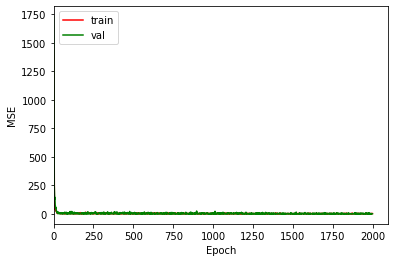

In [20]:
plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('loss_dropoutJLA.png', dpi=100)

In [21]:
# ranz = np.random.uniform(np.min(z), np.max(z), size=31)
ranz = np.linspace(0.01, 1.3, 31)

ranzz = scalerz.transform(ranz.reshape((-1,1)))

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model2.predict(ranzz)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$

(31,)
(200, 31)
<class 'numpy.ndarray'>


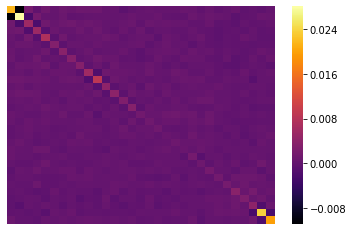

In [22]:
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))
print(type(encoded_imgs))
for i, avg in enumerate(avg_encoded):
    alpha = avg/zz[i]
    fake_encoded[0, i] = alpha * ranzz[i]
decoded_fake = decoder2.predict(fake_encoded)
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
sns.heatmap(pd.DataFrame(decoded_fake.reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [23]:
Om = 0.27
# variance network
w0 = -1

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [24]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

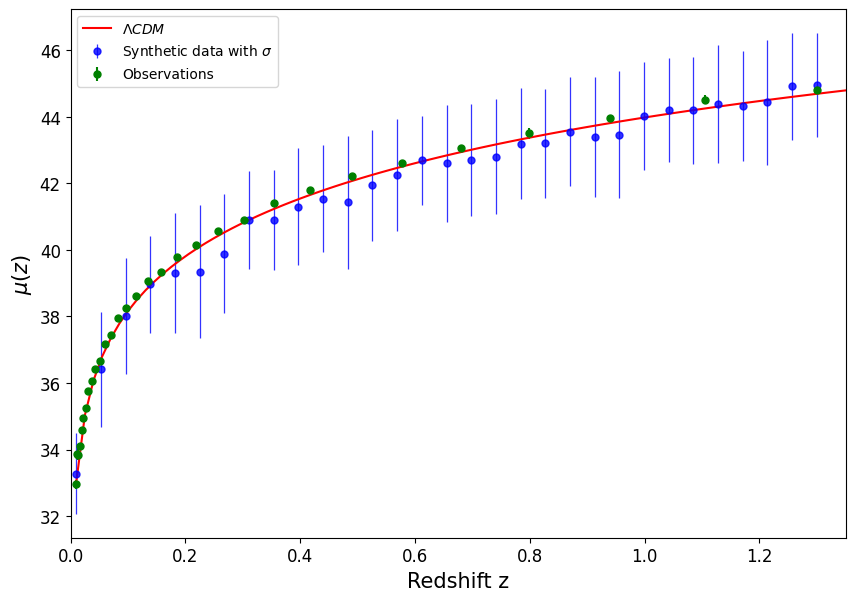

In [31]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)

fakeerrors2 = np.sqrt(np.abs(np.diagonal(prediction_mc_dropout_dec .reshape(31,31))))

# std_dropout_diag = np.sqrt(np.abs(np.diagonal(std_mc_dropout_dec.reshape(31,31))))
std_dropout_diag = np.diagonal(std_mc_dropout_dec.reshape(31,31))

# sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 + std_dropout_diag)
sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 **2 + std_dropout_diag)

plt.errorbar(ranz, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift z', fontsize=15)
plt.ylabel('$\mu(z)$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.savefig('DL_dropout5.png', dpi=80)

In [26]:
matrix_with_all_err = prediction_mc_dropout_dec[0, :].reshape(31,31)
np.fill_diagonal(matrix_with_all_err, sigma**2)

In [27]:
# np.savetxt("fake_binned_JLA_COVdecodedDO3.dat", prediction_mc_dropout_dec.reshape(31,31), delimiter= " ", header="#fake COV")
# np.savetxt("fake_binned_JLA_COVdecodedDO2.dat", prediction_mc_dropout_dec[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
# np.savetxt("fake_binned_JLA_COVdecodedDO3.dat", predictions_dec[10].reshape(31,31), delimiter= " ", header="#fake COV")
# predictions_dec
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
# fake_data2 = np.concatenate((x_test.reshape(-1,1), predictions[10]), axis=1)
# np.savetxt("fake_binned_JLADO2.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

In [28]:
# autoencoder2.save('autoencoderJLA_DO.h5')
# decoder2.save('decoderJLA_DO.h5')
# neural_model2.save('FFNN_JLA_DO.h5')
# encoder2.save('encoderJLA_DO.h5')